# Global Imports

In order to run the code in this notebook, you need to have TensorFlow and Keras (with TensorFlow backend) installed.

Below are the necessary imports, as well as some helper functions used throughout. Execute these each time you open the notebook.

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

%matplotlib inline
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import sys

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6443328691620559306, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3175455129
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13858434245801736407
 physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [2]:
# Needed for resetting a tensorflow graph
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)


def random_batch(X_train, y_train, batch_size):
    index_set = np.random.randint(0, X_train.shape[0], batch_size)
    X_batch = X_train[index_set]
    y_batch = y_train[index_set]
    return X_batch, y_batch


def plot_image(image, pad=2):
    image = image - image.min()
    
    if len(image.shape) == 3:
        channels = image.shape[2]
    else:
        channels = 1
        
    if channels == 1:
        plt.imshow(image.reshape([height,width]), cmap="Greys", interpolation="nearest")
    else:
        plt.imshow(image)
    plt.axis("off")
    

def combine_images(images, rows=None, cols=None):
    n_images = images.shape[0]
    shape = images.shape[1:]
    
    if rows == None or cols == None:
        cols = int(math.sqrt(n_images))
        rows = int(math.floor(float(n_images)/cols))
    
    if len(shape) == 3:
        channels = shape[2]
    else:
        channels = 1
    
    if channels == 1:
        image = np.zeros((rows*shape[0], cols*shape[1]), dtype=images.dtype)
    else:
        image = np.zeros((rows*shape[0], cols*shape[1], shape[2]), dtype=images.dtype)
    #print(generated_images.shape, shape, image.shape)
    
    for row in range(rows):
        for col in range(cols):
            img_index = row * cols + col
            img = images[img_index]
            if channels == 1:
                image[
                    row*shape[0]:(row+1)*shape[0], 
                    col*shape[1]:(col+1)*shape[1]
                ] = img.reshape((shape[0], shape[1]))
            else:
                image[
                    row*shape[0]:(row+1)*shape[0], 
                    col*shape[1]:(col+1)*shape[1],
                    :
                ] = img.reshape((shape[0], shape[1], shape[2]))
    return image

# Stacked Autoencoders

An autoencoder is a type of neural network that can learn efficient representations of the data (called *codings*). It is comprised of stacking two neural networks together: an *encoder* followed by a *decoder*.

For example, the MNIST dataset contains images of size $28\times28\times1$, a total of $784$ features which could be decreased to a vector of size at least 10 (since there are 10 labels), but to add variation in the reconstruction.

## Data Import (MNIST)

In [3]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape, y_train.shape)

height = X_train.shape[1]
width = X_train.shape[2]
channels = 1

X_train = X_train.astype(np.float32) / 255.0 #ensure pixel values are between 0 and 1
X_train = X_train.reshape((X_train.shape[0], height, width, channels))
X_test = X_test.astype(np.float32) / 255.0 #ensure pixel values are between 0 and 1
X_test = X_test.reshape((X_test.shape[0], height, width, channels))

# Run this if you don't use the whole training set
if False:
    m = 10000
    random_indeces = np.random.randint(0, X_train.shape[0], np.min(m, X_train.shape[0]))
    X_train = X_train[random_indeces]

print(X_train.shape, X_test.shape)

Using TensorFlow backend.


(60000, 28, 28) (60000,)
(60000, 28, 28, 1) (10000, 28, 28, 1)


## Dense Model `k_auto0`

A dense autoencoder for MNIST consists of a dense neural network with a layout similar to this:
<img src="./images/autoencoder_dense.png" style="width:50%">

The hidden layers 1 and 3 are not necessary. For instance, one can also use a simpler architecture such as inputs -> codings -> outputs. In this case, we can think of the codings as a projection of the input space onto a smaller dimensional subspace. 

In fact, if we don't use any nonlinear activations, training will result in the model trying to create codings (projections) that maximize the distance between the projected training instances, essentially performing PCA.

In [4]:
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers.core import Activation, Dense, Flatten, Reshape
from keras.layers import Dropout, LeakyReLU
from keras.layers.normalization import BatchNormalization

# For saving images if you use a custom training algorithm
save_path = "images/auto/mnist/k_auto0_"
save_path0 = "images/auto/mnist/zero/k_auto0_"

# For saving/restoring model
encoder_file = 'models/auto/mnist/k_auto0-enc'
decoder_file = 'models/auto/mnist/k_auto0-dec'
model_file = 'models/auto/mnist/k_auto0-model'

In [5]:
# Build the encoder part of the model
#
n_inputs = height * width * channels
n_codings = 40

encoder = Sequential(name="encoder")

encoder.add(Flatten(input_shape=(height, width, channels, ), name="input"))

encoder.add(Dense(units=250, activation='relu', name='hidden_1'))

# Codings layer - I choose the codings to be between 0 and 1, but you don't have to
encoder.add(Dense(units=n_codings, activation='sigmoid', name='codings'))

encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Flatten)              (None, 784)               0         
_________________________________________________________________
hidden_1 (Dense)             (None, 250)               196250    
_________________________________________________________________
codings (Dense)              (None, 40)                10040     
Total params: 206,290
Trainable params: 206,290
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Build the decoder part of the model
#
n_outputs = n_inputs

decoder = Sequential(name="decoder")

decoder.add(Dense(units=320, activation='relu', input_shape=(n_codings,), name='hidden_3'))
decoder.add(Dense(units=n_outputs, activation='sigmoid', name='output_flat'))
decoder.add(Reshape(target_shape=(height,width,channels), name='output'))

decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_3 (Dense)             (None, 320)               13120     
_________________________________________________________________
output_flat (Dense)          (None, 784)               251664    
_________________________________________________________________
output (Reshape)             (None, 28, 28, 1)         0         
Total params: 264,784
Trainable params: 264,784
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Stack the two together
#
# NOTE: this could have all been done in a single sequential model, but I chose
# this approach to be able to feed random values into the decoder and see what happens
#
model = Sequential()
model.add(encoder)
model.add(decoder)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 40)                206290    
_________________________________________________________________
decoder (Sequential)         (None, 28, 28, 1)         264784    
Total params: 471,074
Trainable params: 471,074
Non-trainable params: 0
_________________________________________________________________


### Optimizer

In [8]:
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta

#optimizer = SGD()
#optimizer = SGD(lr=0.003, momentum=0.7, nesterov=True)
optimizer = Adam()
#optimizer = Adam(lr=0.001)
#optimizer = RMSprop()
#optimizer = RMSprop(lr=0.001)
#optimizer = Adagrad()
#optimizer = Adagrad(lr=0.001)
#optimizer = Adadelta(lr=0.15)


encoder.compile(loss='binary_crossentropy', optimizer="adam")
decoder.compile(loss='binary_crossentropy', optimizer="adam")
model.compile(loss='mean_squared_error', optimizer=optimizer)

### Train

In [9]:
epochs = 30
batch_size = 250
val_split=0.15 # how much TRAIN is reserved for VALIDATION

history = model.fit(
    X_train, X_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=val_split
)

score = model.evaluate(X_test, X_test, verbose=1)
print("Test score:", score)

Train on 51000 samples, validate on 9000 samples
Epoch 1/30
51000/51000 [==============================] - 2s 40us/step - loss: 0.0732 - val_loss: 0.0589
Epoch 2/30
51000/51000 [==============================] - 1s 26us/step - loss: 0.0524 - val_loss: 0.0459
Epoch 3/30
51000/51000 [==============================] - 1s 25us/step - loss: 0.0429 - val_loss: 0.0400
Epoch 4/30
51000/51000 [==============================] - 1s 25us/step - loss: 0.0390 - val_loss: 0.0371
Epoch 5/30
51000/51000 [==============================] - 1s 27us/step - loss: 0.0359 - val_loss: 0.0336
Epoch 6/30
51000/51000 [==============================] - 1s 26us/step - loss: 0.0319 - val_loss: 0.0299
Epoch 7/30
51000/51000 [==============================] - 1s 26us/step - loss: 0.0286 - val_loss: 0.0272
Epoch 8/30
51000/51000 [==============================] - 1s 25us/step - loss: 0.0263 - val_loss: 0.0252
Epoch 9/30
51000/51000 [==============================] - 1s 25us/step - loss: 0.0250 - val_loss: 0.0243
Epoch 

In [10]:
# Save the encoder, decoder, and stacked models
#
encoder.save(encoder_file + '.h5')
decoder.save(decoder_file + '.h5')
model.save(model_file + '.h5')

### Reconstruction Output

Let's take a look at how well the reconstructions look:

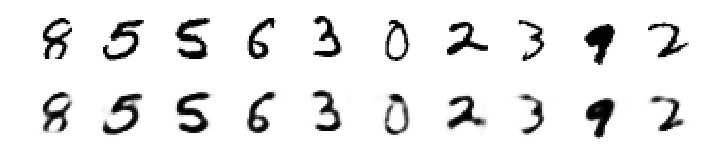

In [11]:
from keras.models import load_model

n_digits = 10
n_codings = 40

model_file = 'models/auto/mnist/k_auto0-model'
model = load_model(model_file + '.h5')

images_in, _ = random_batch(X_test, y_test, batch_size=n_digits)
images_out = model.predict(images_in)

fig = plt.figure(figsize=(12, 2.5))
for digit_index in range(n_digits):
    plt.subplot(2, n_digits, digit_index + 1)
    plot_image(images_in[digit_index].reshape(28,28))
    
    plt.subplot(2, n_digits, n_digits + digit_index + 1)
    plot_image(images_out[digit_index].reshape(28,28))
plt.show()

The reconstructions look slightly blurry, but overall very good! We might be able to get away with encodings of smaller dimension.

### Random Encodings

One thing to try is to feed a randomly generated encoding vector into the decoder. Let's see what we get if we use the model `k_auto0`:

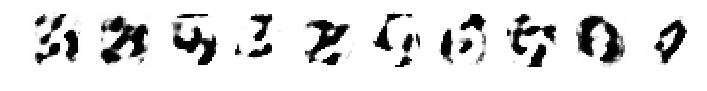

In [12]:
from keras.models import load_model

n_digits = 10
n_codings = 40
decoder_file = 'models/auto/mnist/k_auto0-dec'
decoder = load_model(decoder_file + '.h5')

#codings_in = noise = np.random.uniform(0, 1, n_digits * n_codings).reshape((n_digits, n_codings))
codings_in = noise = np.random.normal(0, 1, n_digits * n_codings).reshape((n_digits, n_codings))
images_out = decoder.predict(codings_in)

fig = plt.figure(figsize=(12, 2))
for digit_index in range(n_digits):
    plt.subplot(1, n_digits, digit_index + 1)
    plot_image(images_out[digit_index].reshape(28,28))
plt.show()

### Encoding Distributions

Decoding a randomly generated encoding vector does NOT result in very clear images that look like those in the MNIST dataset. They have some resemblance, but it's vague.

Let's have a look at what actual encodings look like, to see how we can remedy the problem. First we use the encoder model `k_auto0` to encode the entire training set.

In [13]:
from keras.models import load_model

encoder_file = 'models/auto/mnist/k_auto0-enc'
encoder = load_model(encoder_file + '.h5')
encoder.compile(loss='binary_crossentropy', optimizer="adam")

X_encoded = encoder.predict(X_train, verbose=True)
print(X_encoded.shape)

60000/60000 [==============================] - 2s 35us/step
(60000, 40)


Let's plot a few of the encoded vectors' coodinates:

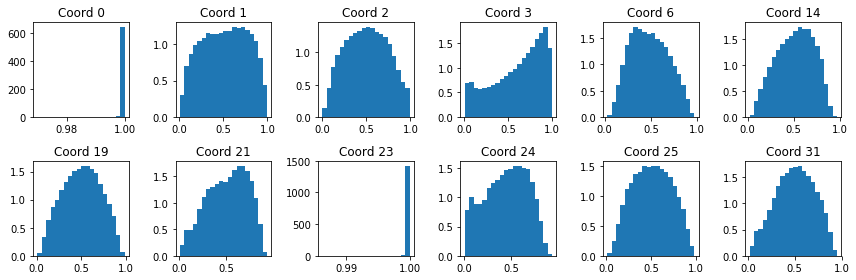

In [14]:
showAll = False

coord_indeces = np.array([
    [  0,  1,  2,  3,  6, 14],
    [ 19, 21, 23, 24, 25, 31]
])

if showAll:
    n_cols = 8
    n_rows = X_encoded.shape[1] // n_cols
else:
    n_cols = coord_indeces.shape[1]
    n_rows = coord_indeces.shape[0]

plt.figure(figsize=(12, int(12.0/n_cols * n_rows)))
for row in range(n_rows):
    for col in range(n_cols):
        i = row * n_cols + col
        plt.subplot(n_rows, n_cols, i + 1)
        if showAll:
            plt.title("Coord " + str(i))
            plt.hist(X_encoded[:, i], bins=20, density=True)
        else:
            plt.title("Coord " + str(coord_indeces[row, col]))
            plt.hist(X_encoded[:, coord_indeces[row, col]], bins=20, density=True)
plt.tight_layout()
plt.show()

The distributions of the coordinates are all different. No wonder feeding in a random encoding vector with coordinates sampled from a gaussian distribution didn't generate anything legible!

*Variational autoencoders* solve this problem.

## Conv Model `k_auto_conv0`

Instead of using dense layers, it is common to use convolutional layers when working with images:

<img src="./images/autoencoder_convolutional.png" style="width:50%">

In [15]:
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers.core import Activation, Dense, Flatten, Reshape
from keras.layers import Dropout, LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers.convolutional import MaxPooling2D, AveragePooling2D

# For saving images if you use a custom training algorithm
save_path = "images/auto/mnist/k_auto_conv0_"
save_path0 = "images/auto/mnist/zero/k_auto_conv0_"

# For saving/restoring model
encoder_file = 'models/auto/mnist/k_auto_conv0-enc'
decoder_file = 'models/auto/mnist/k_auto_conv0-dec'
model_file = 'models/auto/mnist/k_auto_conv0-model'

In [16]:
# Build the encoder part of the model
#
n_inputs = height * width * channels

encoder = Sequential(name="encoder")

encoder.add(Conv2D(filters=6, kernel_size=5, strides=1, padding='same', 
                   input_shape=(height,width,channels)))
encoder.add(Activation('relu'))
encoder.add(MaxPooling2D(pool_size=(2, 2), name="layer_1"))

encoder.add(Conv2D(filters=12, kernel_size=5, strides=1, padding='same'))
encoder.add(Activation('sigmoid'))
encoder.add(MaxPooling2D(pool_size=(2, 2), name="maxpool_2"))

encoder.add(Flatten(name="codings"))

encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 6)         0         
_________________________________________________________________
layer_1 (MaxPooling2D)       (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 12)        1812      
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 12)        0         
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (None, 7, 7, 12)          0         
_________________________________________________________________
codings (Flatten)            (None, 588)               0         
Total para

In [17]:
print(encoder.layers[-2].output_shape[1:])

(7, 7, 12)


In [18]:
# Build the decoder part of the model
#
n_outputs = n_inputs
n_codings = encoder.layers[-1].output_shape[1]
reshape = encoder.layers[-2].output_shape[1:]

decoder = Sequential(name="decoder")

decoder.add(Reshape(input_shape=(n_codings, ), target_shape=reshape, name='codings_in'))

decoder.add(UpSampling2D(size=(2,2)))
decoder.add(Conv2D(filters=8, kernel_size=6, strides=1, padding='same'))
decoder.add(Activation('relu'))

decoder.add(UpSampling2D(size=(2,2)))
decoder.add(Conv2D(filters=4, kernel_size=9, strides=1, padding='same'))
decoder.add(Activation('relu'))

decoder.add(Conv2D(filters=1, kernel_size=5, strides=1, padding='same'))
decoder.add(Activation('sigmoid'))

decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
codings_in (Reshape)         (None, 7, 7, 12)          0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 12)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 8)         3464      
_________________________________________________________________
activation_3 (Activation)    (None, 14, 14, 8)         0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 28, 28, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 4)         2596      
_________________________________________________________________
activation_4 (Activation)    (None, 28, 28, 4)         0         
__________

In [19]:
# Stack the two together
#
# NOTE: this could have all been done in a single sequential model, but I chose
# this approach to be able to feed random values into the decoder and see what happens
#
model = Sequential()
model.add(encoder)
model.add(decoder)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 588)               1968      
_________________________________________________________________
decoder (Sequential)         (None, 28, 28, 1)         6161      
Total params: 8,129
Trainable params: 8,129
Non-trainable params: 0
_________________________________________________________________


### Optimizer

In [20]:
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta

optimizer = SGD()
#optimizer = SGD(lr=0.003, momentum=0.7, nesterov=True)
#optimizer = Adam()
#optimizer = Adam(lr=0.001)
#optimizer = RMSprop()
#optimizer = RMSprop(lr=0.001)
#optimizer = Adagrad()
#optimizer = Adagrad(lr=0.001)
#optimizer = Adadelta(lr=0.15)


encoder.compile(loss='binary_crossentropy', optimizer="adam")
decoder.compile(loss='binary_crossentropy', optimizer="adam")
model.compile(loss='mean_squared_error', optimizer=optimizer)

### Train

In [21]:
epochs = 10
batch_size = 200
val_split=0.10 # how much TRAIN is reserved for VALIDATION

history = model.fit(
    X_train, X_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=val_split
)

score = model.evaluate(X_test, X_test, verbose=1)
print("Test score:", score)

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 9s 176us/step - loss: 0.1240 - val_loss: 0.1071
Epoch 2/10
54000/54000 [==============================] - 7s 127us/step - loss: 0.0927 - val_loss: 0.0784
Epoch 3/10
54000/54000 [==============================] - 7s 126us/step - loss: 0.0730 - val_loss: 0.0699
Epoch 4/10
54000/54000 [==============================] - 7s 126us/step - loss: 0.0651 - val_loss: 0.0620
Epoch 5/10
54000/54000 [==============================] - 7s 126us/step - loss: 0.0598 - val_loss: 0.0577
Epoch 6/10
54000/54000 [==============================] - 7s 125us/step - loss: 0.0552 - val_loss: 0.0537
Epoch 7/10
54000/54000 [==============================] - 7s 126us/step - loss: 0.0513 - val_loss: 0.0500
Epoch 8/10
54000/54000 [==============================] - 7s 126us/step - loss: 0.0475 - val_loss: 0.0461
Epoch 9/10
54000/54000 [==============================] - 7s 126us/step - loss: 0.0441 - val_loss: 0.04

In [22]:
# Save the encoder, decoder, and stacked models
#
encoder.save(encoder_file + '.h5')
decoder.save(decoder_file + '.h5')
model.save(model_file + '.h5')

### Reconstruction Output

Let's take a look at how well the reconstructions look:

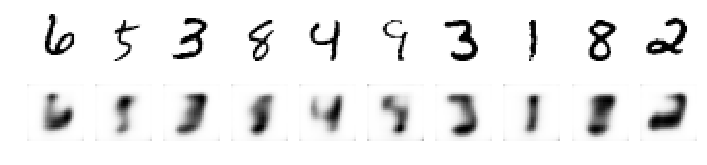

In [23]:
from keras.models import load_model

n_digits = 10
n_codings = 588 #from the encoder number

#model_file = 'models/auto/mnist/k_auto_conv0-model'
#model = load_model(model_file + '.h5')

images_in, _ = random_batch(X_test, y_test, batch_size=n_digits)
images_out = model.predict(images_in)

fig = plt.figure(figsize=(12, 2.5))
for digit_index in range(n_digits):
    plt.subplot(2, n_digits, digit_index + 1)
    plot_image(images_in[digit_index].reshape(28,28))
    
    plt.subplot(2, n_digits, n_digits + digit_index + 1)
    plot_image(images_out[digit_index].reshape(28,28))
plt.show()

As an exercise, try to improve this model. Some things you can try:
* add more feature maps
* add a dense layer before/after the codings (similar to the Dense model)

## Dense Model `k_auto1`

What happens if we don't apply the sigmoid activation to the model?

In [24]:
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers.core import Activation, Dense, Flatten, Reshape
from keras.layers import Dropout, LeakyReLU
from keras.layers.normalization import BatchNormalization

# For saving images if you use a custom training algorithm
save_path = "images/auto/mnist/k_auto1_"
save_path0 = "images/auto/mnist/zero/k_auto1_"

# For saving/restoring model
encoder_file = 'models/auto/mnist/k_auto1-enc'
decoder_file = 'models/auto/mnist/k_auto1-dec'
model_file = 'models/auto/mnist/k_auto1-model'

In [25]:
# Build the encoder part of the model
#
n_inputs = height * width * channels
n_codings = 40

encoder = Sequential(name="encoder")

encoder.add(Flatten(input_shape=(height, width, channels, ), name="input"))

encoder.add(Dense(units=250, activation='relu', name='hidden_1'))

# Codings layer - no activation
encoder.add(Dense(units=n_codings, name='codings'))

encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Flatten)              (None, 784)               0         
_________________________________________________________________
hidden_1 (Dense)             (None, 250)               196250    
_________________________________________________________________
codings (Dense)              (None, 40)                10040     
Total params: 206,290
Trainable params: 206,290
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Build the decoder part of the model
#
n_outputs = n_inputs

decoder = Sequential(name="decoder")

decoder.add(Dense(units=320, activation='relu', input_shape=(n_codings,), name='hidden_3'))
decoder.add(Dense(units=n_outputs, activation='sigmoid', name='output_flat'))
decoder.add(Reshape(target_shape=(height,width,channels), name='output'))

decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_3 (Dense)             (None, 320)               13120     
_________________________________________________________________
output_flat (Dense)          (None, 784)               251664    
_________________________________________________________________
output (Reshape)             (None, 28, 28, 1)         0         
Total params: 264,784
Trainable params: 264,784
Non-trainable params: 0
_________________________________________________________________


In [27]:
# Stack the two together
#
# NOTE: this could have all been done in a single sequential model, but I chose
# this approach to be able to feed random values into the decoder and see what happens
#
model = Sequential()
model.add(encoder)
model.add(decoder)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 40)                206290    
_________________________________________________________________
decoder (Sequential)         (None, 28, 28, 1)         264784    
Total params: 471,074
Trainable params: 471,074
Non-trainable params: 0
_________________________________________________________________


### Optimizer

In [28]:
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta

#optimizer = SGD()
#optimizer = SGD(lr=0.003, momentum=0.7, nesterov=True)
optimizer = Adam()
#optimizer = Adam(lr=0.001)
#optimizer = RMSprop()
#optimizer = RMSprop(lr=0.001)
#optimizer = Adagrad()
#optimizer = Adagrad(lr=0.001)
#optimizer = Adadelta(lr=0.15)


encoder.compile(loss='binary_crossentropy', optimizer="adam")
decoder.compile(loss='binary_crossentropy', optimizer="adam")
model.compile(loss='mean_squared_error', optimizer=optimizer)

### Train

In [29]:
epochs = 30
batch_size = 250
val_split=0.15 # how much TRAIN is reserved for VALIDATION

history = model.fit(
    X_train, X_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=val_split
)

score = model.evaluate(X_test, X_test, verbose=1)
print("Test score:", score)

Train on 51000 samples, validate on 9000 samples
Epoch 1/30
51000/51000 [==============================] - 2s 34us/step - loss: 0.0531 - val_loss: 0.0278
Epoch 2/30
51000/51000 [==============================] - 1s 26us/step - loss: 0.0217 - val_loss: 0.0173
Epoch 3/30
51000/51000 [==============================] - 1s 26us/step - loss: 0.0150 - val_loss: 0.0130
Epoch 4/30
51000/51000 [==============================] - 1s 25us/step - loss: 0.0117 - val_loss: 0.0108
Epoch 5/30
51000/51000 [==============================] - 1s 25us/step - loss: 0.0101 - val_loss: 0.0096
Epoch 6/30
51000/51000 [==============================] - 1s 27us/step - loss: 0.0091 - val_loss: 0.0088
Epoch 7/30
51000/51000 [==============================] - 1s 26us/step - loss: 0.0085 - val_loss: 0.0083
Epoch 8/30
51000/51000 [==============================] - 1s 26us/step - loss: 0.0079 - val_loss: 0.0077
Epoch 9/30
51000/51000 [==============================] - 1s 27us/step - loss: 0.0074 - val_loss: 0.0073
Epoch 

In [30]:
# Save the encoder, decoder, and stacked models
#
encoder.save(encoder_file + '.h5')
decoder.save(decoder_file + '.h5')
model.save(model_file + '.h5')

### Reconstruction Output

Let's take a look at how well the reconstructions look:

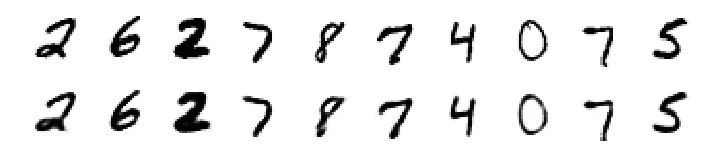

In [31]:
from keras.models import load_model

n_digits = 10
n_codings = 40

model_file = 'models/auto/mnist/k_auto1-model'
model = load_model(model_file + '.h5')

images_in, _ = random_batch(X_test, y_test, batch_size=n_digits)
images_out = model.predict(images_in)

fig = plt.figure(figsize=(12, 2.5))
for digit_index in range(n_digits):
    plt.subplot(2, n_digits, digit_index + 1)
    plot_image(images_in[digit_index].reshape(28,28))
    
    plt.subplot(2, n_digits, n_digits + digit_index + 1)
    plot_image(images_out[digit_index].reshape(28,28))
plt.show()

### Random Encodings

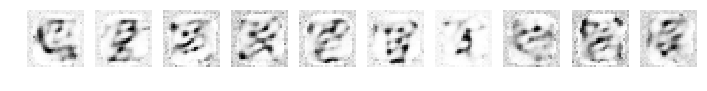

In [32]:
from keras.models import load_model

n_digits = 10
n_codings = 40
decoder_file = 'models/auto/mnist/k_auto1-dec'
decoder = load_model(decoder_file + '.h5')

#codings_in = noise = np.random.uniform(-3, 3, n_digits * n_codings).reshape((n_digits, n_codings))
codings_in = noise = np.random.normal(0, 1, n_digits * n_codings).reshape((n_digits, n_codings))
images_out = decoder.predict(codings_in)

fig = plt.figure(figsize=(12, 2))
for digit_index in range(n_digits):
    plt.subplot(1, n_digits, digit_index + 1)
    plot_image(images_out[digit_index].reshape(28,28))
plt.show()

### Encoding Distributions

In [33]:
from keras.models import load_model

encoder_file = 'models/auto/mnist/k_auto1-enc'
encoder = load_model(encoder_file + '.h5')
encoder.compile(loss='binary_crossentropy', optimizer="adam")

X_encoded = encoder.predict(X_train, verbose=True)
print(X_encoded.shape)

60000/60000 [==============================] - 3s 42us/step
(60000, 40)


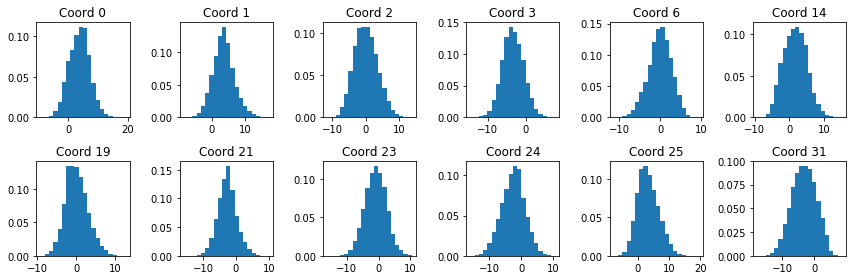

In [34]:
showAll = False

coord_indeces = np.array([
    [  0,  1,  2,  3,  6, 14],
    [ 19, 21, 23, 24, 25, 31]
])

if showAll:
    n_cols = 8
    n_rows = X_encoded.shape[1] // n_cols
else:
    n_cols = coord_indeces.shape[1]
    n_rows = coord_indeces.shape[0]

plt.figure(figsize=(12, int(12.0/n_cols * n_rows)))
for row in range(n_rows):
    for col in range(n_cols):
        i = row * n_cols + col
        plt.subplot(n_rows, n_cols, i + 1)
        if showAll:
            plt.title("Coord " + str(i))
            plt.hist(X_encoded[:, i], bins=20, density=True)
        else:
            plt.title("Coord " + str(coord_indeces[row, col]))
            plt.hist(X_encoded[:, coord_indeces[row, col]], bins=20, density=True)
plt.tight_layout()
plt.show()

# Variational Autoencoders

## Data Import (MNIST)

In [35]:
from keras.datasets import mnist
from keras.utils import np_utils, plot_model


(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape, y_train.shape)

height = X_train.shape[1]
width = X_train.shape[2]
channels = 1

X_train = X_train.astype(np.float32) / 255.0 #ensure pixel values are between 0 and 1
X_train = X_train.reshape((X_train.shape[0], height, width, channels))
X_test = X_test.astype(np.float32) / 255.0 #ensure pixel values are between 0 and 1
X_test = X_test.reshape((X_test.shape[0], height, width, channels))

# Run this if you don't use the whole training set
if False:
    m = 10000
    random_indeces = np.random.randint(0, X_train.shape[0], np.min(m, X_train.shape[0]))
    X_train = X_train[random_indeces]

print(X_train.shape, X_test.shape)

(60000, 28, 28) (60000,)
(60000, 28, 28, 1) (10000, 28, 28, 1)


## Model `k_auto_var0`

In [36]:
from keras import backend as K
from keras.models import Model, Sequential
from keras.engine.input_layer import Input
from keras.layers.core import Activation, Dense, Flatten, Reshape, Lambda
from keras.layers import Dropout, LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers.convolutional import MaxPooling2D, AveragePooling2D

# For saving images if you use a custom training algorithm
save_path = "images/auto/mnist/k_auto_var0_"
save_path0 = "images/auto/mnist/zero/k_auto_var0_"

# For saving/restoring model
encoder_file = 'models/auto/mnist/k_auto_var0-enc'
decoder_file = 'models/auto/mnist/k_auto_var0-dec'
model_file = 'models/auto/mnist/k_auto_var0-model'

In [37]:
def sampling(args):
    param_0, param_1 = args
    batch_size = K.shape(param_0)[0]
    dim = K.int_shape(param_0)[1]
    
    #unif_01 = K.random_uniform(shape=(batch_size, dim))
    normal_01 = K.random_normal(shape=(batch_size, dim))
    
    return param_0 + param_1 * normal_01
    #return param_0 + K.exp(0.5 * param_1) * normal_01


# Build the encoder part of the model
#
n_inputs = height * width * channels
n_codings = 24

inputs = Input(shape=(height, width, channels,), name='inputs')
inputs_flat = Flatten(name="inputs_flat")(inputs)
hidden1 = Dense(units=250, activation='relu', name='hidden_1')(inputs_flat)

param_0 = Dense(n_codings, name='param_0')(hidden1)
param_1 = Dense(n_codings, name='param_1')(hidden1)
#param_2 = Dense(n_codings, name='param_2')(hidden1) #to play around with

# We feed the param_0 and param_1 into the Lambda layer, whose function is to 
# tranform a random uniform(0,1) variable by applying the parameters
codings = Lambda(sampling, output_shape=(n_codings,), name='codings')([param_0, param_1])

encoder = Model(inputs, [codings, param_0, param_1], name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
inputs_flat (Flatten)           (None, 784)          0           inputs[0][0]                     
__________________________________________________________________________________________________
hidden_1 (Dense)                (None, 250)          196250      inputs_flat[0][0]                
__________________________________________________________________________________________________
param_0 (Dense)                 (None, 24)           6024        hidden_1[0][0]                   
__________________________________________________________________________________________________
param_1 (D

In [38]:
# Build the decoder part of the model
#
n_codings = encoder.layers[-1].output_shape[1]
n_outputs = n_inputs

latent_inputs = Input(shape=(n_codings,), name='latent_inputs')
hidden2 = Dense(320, activation='relu', name="hidden_2")(latent_inputs)
output_flat = Dense(units=n_outputs, activation='sigmoid', name='output_flat')(hidden2)
output = Reshape(target_shape=(height,width,channels,), name='output')(output_flat)

decoder = Model(latent_inputs, output, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
latent_inputs (InputLayer)   (None, 24)                0         
_________________________________________________________________
hidden_2 (Dense)             (None, 320)               8000      
_________________________________________________________________
output_flat (Dense)          (None, 784)               251664    
_________________________________________________________________
output (Reshape)             (None, 28, 28, 1)         0         
Total params: 259,664
Trainable params: 259,664
Non-trainable params: 0
_________________________________________________________________


In [39]:
# Stack the two together
#
outputs = decoder(  encoder(inputs)[0]  )
model = Model(inputs, outputs, name='vae')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 24), (None, 24),  208298    
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         259664    
Total params: 467,962
Trainable params: 467,962
Non-trainable params: 0
_________________________________________________________________


### Loss and Optimizer

In [40]:
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.losses import mse, binary_crossentropy

# Calculate the reconstruction loss. We use MSE. Note that since inputs/outputs are of
# shape (?, 28, 28, 1), we cannot simply call mse(inputs, outputs) as this would result
# in the MSE being calculated only along the last axis=-1, instead of over the entire image
#
# Fix: we use the backend to write the MSE explicitly
#
print("inputs/outputs shapes:", inputs.shape, outputs.shape)
reconstruction_loss = K.sum(K.square(outputs - inputs), axis=[1, 2, 3])
#reconstruction_loss = binary_crossentropy(inputs, outputs)
#reconstruction_loss *= np.sqrt(n_inputs)
#reconstruction_loss *= n_inputs
print("rec_loss:", reconstruction_loss.shape)


# Calculate the distribution loss (KL-div for Gaussian has a closed form)
#
epsilon = 1e-10
#dist_loss = 1 + param_1 - K.square(param_0) - K.exp(param_1)
dist_loss = K.square(param_0) + K.square(param_1) - 1 - K.log( epsilon + K.square(param_1) )
dist_loss = 0.5 * K.sum(dist_loss, axis=-1)
print("dist_loss:", dist_loss.shape)

loss = K.mean(reconstruction_loss + dist_loss)
#loss = K.mean(reconstruction_loss)
#loss = K.mean(dist_loss)
print("loss:", loss.shape)

#optimizer = SGD()
#optimizer = SGD(lr=0.003, momentum=0.7, nesterov=True)
optimizer = Adam()
#optimizer = Adam(lr=0.001)
#optimizer = RMSprop()
#optimizer = RMSprop(lr=0.001)
#optimizer = Adagrad()
#optimizer = Adagrad(lr=0.001)
#optimizer = Adadelta()
#optimizer = Adadelta(lr=0.15)

#encoder.compile(loss='binary_crossentropy', optimizer="adam")
#decoder.compile(loss='binary_crossentropy', optimizer="adam")
model.add_loss(loss)
model.compile(optimizer=optimizer)
model.summary()

inputs/outputs shapes: (?, 28, 28, 1) (?, 28, 28, 1)
rec_loss: (?,)
dist_loss: (?,)
loss: ()
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 24), (None, 24),  208298    
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         259664    
Total params: 467,962
Trainable params: 467,962
Non-trainable params: 0
_________________________________________________________________


### Train

In [41]:
epochs = 50
batch_size = 200
val_split=0.05 # how much TRAIN is reserved for VALIDATION

history = model.fit(
    X_train, batch_size=batch_size, epochs=epochs, verbose=1
)

Epoch 1/50
60000/60000 [==============================] - 2s 37us/step - loss: 56.4804
Epoch 2/50
60000/60000 [==============================] - 2s 28us/step - loss: 39.7520
Epoch 3/50
60000/60000 [==============================] - 2s 29us/step - loss: 37.8799
Epoch 4/50
60000/60000 [==============================] - 2s 29us/step - loss: 36.6169
Epoch 5/50
60000/60000 [==============================] - 2s 28us/step - loss: 34.9980
Epoch 6/50
60000/60000 [==============================] - 2s 29us/step - loss: 33.8751
Epoch 7/50
60000/60000 [==============================] - 2s 28us/step - loss: 33.0929
Epoch 8/50
60000/60000 [==============================] - 2s 29us/step - loss: 33.1189
Epoch 9/50
60000/60000 [==============================] - 2s 28us/step - loss: 32.2410
Epoch 10/50
60000/60000 [==============================] - 2s 29us/step - loss: 32.1722
Epoch 11/50
60000/60000 [==============================] - 2s 29us/step - loss: 31.6892
Epoch 12/50
60000/60000 [================

In [42]:
# Save the encoder, decoder, and stacked models
#
encoder.save(encoder_file + '.h5')
decoder.save(decoder_file + '.h5')
model.save(model_file + '.h5')

### Reconstruction Output

Let's take a look at how well the reconstructions look:

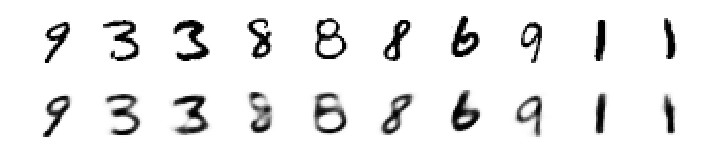

In [43]:
from keras.models import load_model

n_digits = 10
n_codings = 20 #from the encoder number

#model_file = 'models/auto/mnist/k_auto_var0-model'
#model = load_model(model_file + '.h5')

images_in, _ = random_batch(X_test, y_test, batch_size=n_digits)
images_out = model.predict(images_in)

fig = plt.figure(figsize=(12, 2.5))
for digit_index in range(n_digits):
    plt.subplot(2, n_digits, digit_index + 1)
    plot_image(images_in[digit_index].reshape(28,28))
    
    plt.subplot(2, n_digits, n_digits + digit_index + 1)
    plot_image(images_out[digit_index].reshape(28,28))
plt.show()

### Encoding Distributions

In [44]:
from keras.models import load_model

#encoder_file = 'models/auto/mnist/k_auto_var0-enc'
#encoder = load_model(encoder_file + '.h5')
#encoder.compile(loss='binary_crossentropy', optimizer="adam")

# encoder_output contains 3 variables: [ codings, param_0, param_1 ]
encoder_output = encoder.predict(X_test, verbose=True)
print(encoder_output[0].shape)

10000/10000 [==============================] - 1s 62us/step
(10000, 24)


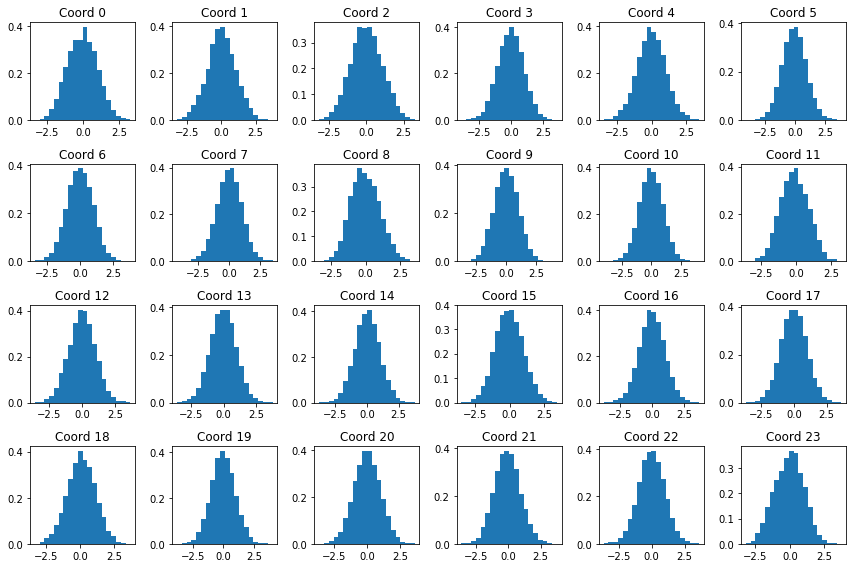

In [45]:
X_encoded = encoder_output[0]
showAll = True

coord_indeces = np.array([
    [ 0, 1, 2, 3, 4],
    [ 5, 6, 7, 8, 9]
])

if showAll:
    n_cols = 6
    n_rows = X_encoded.shape[1] // n_cols
else:
    n_cols = coord_indeces.shape[1]
    n_rows = coord_indeces.shape[0]

plt.figure(figsize=(12, int(12.0/n_cols * n_rows)))
for row in range(n_rows):
    for col in range(n_cols):
        i = row * n_cols + col
        plt.subplot(n_rows, n_cols, i + 1)
        if showAll:
            plt.title("Coord " + str(i))
            plt.hist(X_encoded[:, i], bins=20, density=True)
        else:
            plt.title("Coord " + str(coord_indeces[row, col]))
            plt.hist(X_encoded[:, coord_indeces[row, col]], bins=20, density=True)
plt.tight_layout()
plt.show()

### Generative

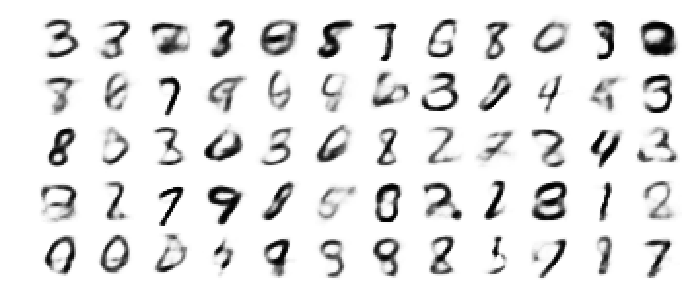

In [46]:
from keras.models import load_model

rows = 5
cols = 12
n_digits = rows * cols

#decoder_file = 'models/auto/mnist/k_auto_var0-dec'
#decoder = load_model(decoder_file + '.h5')
#decoder.compile(loss='binary_crossentropy', optimizer="adam")
n_codings = decoder.layers[0].input_shape[1]

#codings_in = noise = np.random.uniform(-2, 2, n_digits * n_codings).reshape((n_digits, n_codings))
codings_in = noise = np.random.normal(0, 1.0, n_digits * n_codings).reshape((n_digits, n_codings))
images_out = decoder.predict(codings_in)

image = combine_images(images_out, rows, cols)

fig = plt.figure(figsize=(cols, rows))
plt.imshow(image, cmap="Greys", interpolation='nearest')
plt.axis("off")
plt.show()

## Model `k_auto_var1`

In [47]:
from keras import backend as K
from keras.models import Model, Sequential
from keras.engine.input_layer import Input
from keras.layers.core import Activation, Dense, Flatten, Reshape, Lambda
from keras.layers import Dropout, LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers.convolutional import MaxPooling2D, AveragePooling2D

# For saving images if you use a custom training algorithm
save_path = "images/auto/mnist/k_auto_var1_"
save_path0 = "images/auto/mnist/zero/k_auto_var1_"

# For saving/restoring model
encoder_file = 'models/auto/mnist/k_auto_var1-enc'
decoder_file = 'models/auto/mnist/k_auto_var1-dec'
model_file = 'models/auto/mnist/k_auto_var1-model'

In [48]:
def sampling(args):
    param_0, param_1 = args
    batch_size = K.shape(param_0)[0]
    dim = K.int_shape(param_0)[1]
    
    #unif_01 = K.random_uniform(shape=(batch_size, dim))
    normal_01 = K.random_normal(shape=(batch_size, dim))
    
    #return param_0 + param_1 * normal_01
    return param_0 + K.exp(0.5 * param_1) * normal_01


# Build the encoder part of the model
#
n_inputs = height * width * channels
n_codings = 24

inputs = Input(shape=(height, width, channels,), name='inputs')
inputs_flat = Flatten(name="inputs_flat")(inputs)
hidden1 = Dense(units=250, activation='relu', name='hidden_1')(inputs_flat)

param_0 = Dense(n_codings, name='param_0')(hidden1)
param_1 = Dense(n_codings, name='param_1')(hidden1)
#param_2 = Dense(n_codings, name='param_2')(hidden1) #to play around with

# We feed the param_0 and param_1 into the Lambda layer, whose function is to 
# tranform a random uniform(0,1) variable by applying the parameters
codings = Lambda(sampling, output_shape=(n_codings,), name='codings')([param_0, param_1])

encoder = Model(inputs, [codings, param_0, param_1], name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
inputs_flat (Flatten)           (None, 784)          0           inputs[0][0]                     
__________________________________________________________________________________________________
hidden_1 (Dense)                (None, 250)          196250      inputs_flat[0][0]                
__________________________________________________________________________________________________
param_0 (Dense)                 (None, 24)           6024        hidden_1[0][0]                   
__________________________________________________________________________________________________
param_1 (D

In [49]:
# Build the decoder part of the model
#
n_codings = encoder.layers[-1].output_shape[1]
n_outputs = n_inputs

latent_inputs = Input(shape=(n_codings,), name='latent_inputs')
hidden2 = Dense(320, activation='relu', name="hidden_2")(latent_inputs)
output_flat = Dense(units=n_outputs, activation='sigmoid', name='output_flat')(hidden2)
output = Reshape(target_shape=(height,width,channels,), name='output')(output_flat)

decoder = Model(latent_inputs, output, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
latent_inputs (InputLayer)   (None, 24)                0         
_________________________________________________________________
hidden_2 (Dense)             (None, 320)               8000      
_________________________________________________________________
output_flat (Dense)          (None, 784)               251664    
_________________________________________________________________
output (Reshape)             (None, 28, 28, 1)         0         
Total params: 259,664
Trainable params: 259,664
Non-trainable params: 0
_________________________________________________________________


In [50]:
# Stack the two together
#
outputs = decoder(  encoder(inputs)[0]  )
model = Model(inputs, outputs, name='vae')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 24), (None, 24),  208298    
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         259664    
Total params: 467,962
Trainable params: 467,962
Non-trainable params: 0
_________________________________________________________________


### Loss and Optimizer

In [51]:
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.losses import mse, binary_crossentropy

# Calculate the reconstruction loss. We use MSE. Note that since inputs/outputs are of
# shape (?, 28, 28, 1), we cannot simply call mse(inputs, outputs) as this would result
# in the MSE being calculated only along the last axis=-1, instead of over the entire image
#
# Fix: we use the backend to write the MSE explicitly
#
print("inputs/outputs shapes:", inputs.shape, outputs.shape)
reconstruction_loss = K.sum(K.square(outputs - inputs), axis=[1, 2, 3])
#reconstruction_loss = binary_crossentropy(inputs, outputs)
#reconstruction_loss *= np.sqrt(n_inputs)
#reconstruction_loss *= n_inputs
print("rec_loss:", reconstruction_loss.shape)


# Calculate the distribution loss (KL-div for Gaussian has a closed form)
#
epsilon = 1e-10
dist_loss = K.square(param_0) + K.exp(param_1) - 1 - param_1
#dist_loss = K.square(param_0) + K.square(param_1) - 1 - K.log( epsilon + K.square(param_1) )
dist_loss = 0.5 * K.sum(dist_loss, axis=-1)
print("dist_loss:", dist_loss.shape)

loss = K.mean(reconstruction_loss + dist_loss)
#loss = K.mean(reconstruction_loss)
#loss = K.mean(dist_loss)
print("loss:", loss.shape)

#optimizer = SGD()
#optimizer = SGD(lr=0.003, momentum=0.7, nesterov=True)
optimizer = Adam()
#optimizer = Adam(lr=0.001)
#optimizer = RMSprop()
#optimizer = RMSprop(lr=0.001)
#optimizer = Adagrad()
#optimizer = Adagrad(lr=0.001)
#optimizer = Adadelta()
#optimizer = Adadelta(lr=0.15)

#encoder.compile(loss='binary_crossentropy', optimizer="adam")
#decoder.compile(loss='binary_crossentropy', optimizer="adam")
model.add_loss(loss)
model.compile(optimizer=optimizer)
model.summary()

inputs/outputs shapes: (?, 28, 28, 1) (?, 28, 28, 1)
rec_loss: (?,)
dist_loss: (?,)
loss: ()
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 24), (None, 24),  208298    
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         259664    
Total params: 467,962
Trainable params: 467,962
Non-trainable params: 0
_________________________________________________________________


### Train

In [52]:
epochs = 50
batch_size = 150
val_split=0.05 # how much TRAIN is reserved for VALIDATION

history = model.fit(
    X_train, batch_size=batch_size, epochs=epochs, verbose=1
)

Epoch 1/50
60000/60000 [==============================] - 3s 48us/step - loss: 49.9520
Epoch 2/50
60000/60000 [==============================] - 2s 37us/step - loss: 36.9905
Epoch 3/50
60000/60000 [==============================] - 2s 38us/step - loss: 34.6311
Epoch 4/50
60000/60000 [==============================] - 2s 37us/step - loss: 33.3850
Epoch 5/50
60000/60000 [==============================] - 2s 37us/step - loss: 32.6144
Epoch 6/50
60000/60000 [==============================] - 2s 36us/step - loss: 32.0909
Epoch 7/50
60000/60000 [==============================] - 2s 37us/step - loss: 31.7043
Epoch 8/50
60000/60000 [==============================] - 2s 37us/step - loss: 31.4683
Epoch 9/50
60000/60000 [==============================] - 2s 38us/step - loss: 31.2113
Epoch 10/50
60000/60000 [==============================] - 2s 38us/step - loss: 31.0479
Epoch 11/50
60000/60000 [==============================] - 2s 36us/step - loss: 30.9063
Epoch 12/50
60000/60000 [================

In [53]:
# Save the encoder, decoder, and stacked models
#
encoder.save(encoder_file + '.h5')
decoder.save(decoder_file + '.h5')
model.save(model_file + '.h5')

### Reconstruction Output

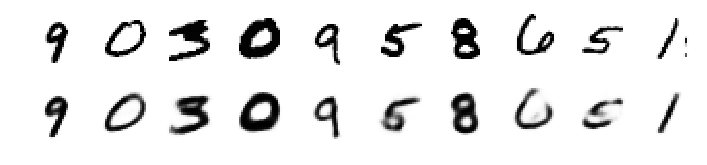

In [54]:
from keras.models import load_model

n_digits = 10
n_codings = 20 #from the encoder number

#model_file = 'models/auto/mnist/k_auto_var1-model'
#model = load_model(model_file + '.h5')

images_in, _ = random_batch(X_test, y_test, batch_size=n_digits)
images_out = model.predict(images_in)

fig = plt.figure(figsize=(12, 2.5))
for digit_index in range(n_digits):
    plt.subplot(2, n_digits, digit_index + 1)
    plot_image(images_in[digit_index].reshape(28,28))
    
    plt.subplot(2, n_digits, n_digits + digit_index + 1)
    plot_image(images_out[digit_index].reshape(28,28))
plt.show()

### Encoding Distributions

In [55]:
from keras.models import load_model

#encoder_file = 'models/auto/mnist/k_auto_var1-enc'
#encoder = load_model(encoder_file + '.h5')
#encoder.compile(loss='binary_crossentropy', optimizer="adam")

# encoder_output contains 3 variables: [ codings, param_0, param_1 ]
encoder_output = encoder.predict(X_test, verbose=True)
print(encoder_output[0].shape)

10000/10000 [==============================] - 1s 54us/step
(10000, 24)


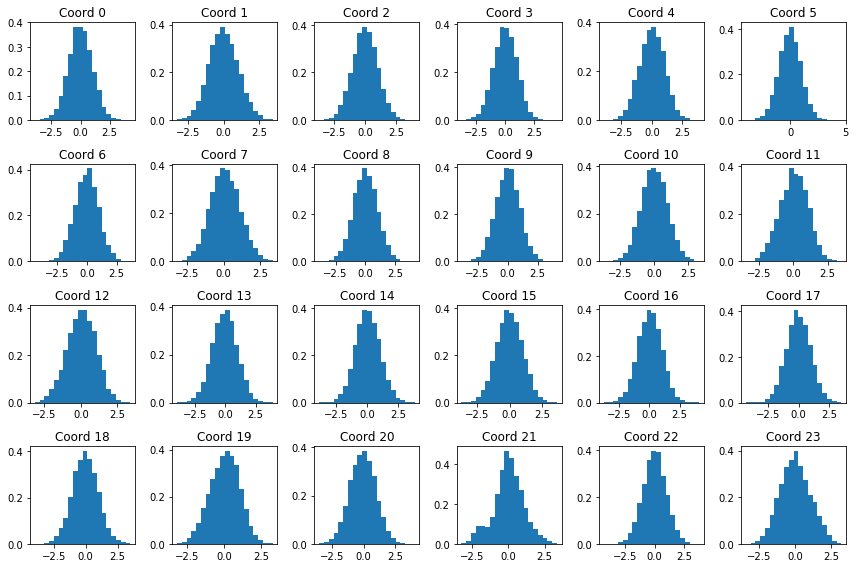

In [56]:
X_encoded = encoder_output[0]
showAll = True

coord_indeces = np.array([
    [ 0, 1, 2, 3, 4],
    [ 5, 6, 7, 8, 9]
])

if showAll:
    n_cols = 6
    n_rows = X_encoded.shape[1] // n_cols
else:
    n_cols = coord_indeces.shape[1]
    n_rows = coord_indeces.shape[0]

plt.figure(figsize=(12, int(12.0/n_cols * n_rows)))
for row in range(n_rows):
    for col in range(n_cols):
        i = row * n_cols + col
        plt.subplot(n_rows, n_cols, i + 1)
        if showAll:
            plt.title("Coord " + str(i))
            plt.hist(X_encoded[:, i], bins=20, density=True)
        else:
            plt.title("Coord " + str(coord_indeces[row, col]))
            plt.hist(X_encoded[:, coord_indeces[row, col]], bins=20, density=True)
plt.tight_layout()
plt.show()

### Generative

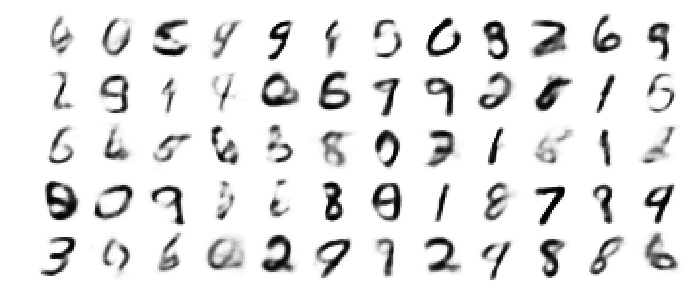

In [57]:
from keras.models import load_model

rows = 5
cols = 12
n_digits = rows * cols

#decoder_file = 'models/auto/mnist/k_auto_var1-dec'
#decoder = load_model(decoder_file + '.h5')
#decoder.compile(loss='binary_crossentropy', optimizer="adam")
n_codings = decoder.layers[0].input_shape[1]

#codings_in = noise = np.random.uniform(-2, 2, n_digits * n_codings).reshape((n_digits, n_codings))
codings_in = noise = np.random.normal(0, 1.0, n_digits * n_codings).reshape((n_digits, n_codings))
images_out = decoder.predict(codings_in)

image = combine_images(images_out, rows, cols)

fig = plt.figure(figsize=(cols, rows))
plt.imshow(image, cmap="Greys", interpolation='nearest')
plt.axis("off")
plt.show()

## Model `k_auto_var2`

A deeper model than `k_auto_var1`

In [58]:
from keras import backend as K
from keras.models import Model, Sequential
from keras.engine.input_layer import Input
from keras.layers.core import Activation, Dense, Flatten, Reshape, Lambda
from keras.layers import Dropout, LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers.convolutional import MaxPooling2D, AveragePooling2D

# For saving images if you use a custom training algorithm
save_path = "images/auto/mnist/k_auto_var2_"
save_path0 = "images/auto/mnist/zero/k_auto_var2_"

# For saving/restoring model
encoder_file = 'models/auto/mnist/k_auto_var2-enc'
decoder_file = 'models/auto/mnist/k_auto_var2-dec'
model_file = 'models/auto/mnist/k_auto_var2-model'

In [59]:
def sampling(args):
    param_0, param_1 = args
    batch_size = K.shape(param_0)[0]
    dim = K.int_shape(param_0)[1]
    
    #unif_01 = K.random_uniform(shape=(batch_size, dim))
    normal_01 = K.random_normal(shape=(batch_size, dim))
    
    #return param_0 + param_1 * normal_01
    return param_0 + K.exp(0.5 * param_1) * normal_01


# Build the encoder part of the model
#
n_inputs = height * width * channels
n_codings = 24

inputs = Input(shape=(height, width, channels,), name='inputs')
inputs_flat = Flatten(name="inputs_flat")(inputs)
hidden1 = Dense(units=360, activation='relu', name='hidden_1')(inputs_flat)
hidden2 = Dense(units=180, activation='relu', name='hidden_2')(hidden1)

param_0 = Dense(n_codings, name='param_0')(hidden2)
param_1 = Dense(n_codings, name='param_1')(hidden2)
#param_2 = Dense(n_codings, name='param_2')(hidden1) #to play around with

# We feed the param_0 and param_1 into the Lambda layer, whose function is to 
# tranform a random uniform(0,1) variable by applying the parameters
codings = Lambda(sampling, output_shape=(n_codings,), name='codings')([param_0, param_1])

encoder = Model(inputs, [codings, param_0, param_1], name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
inputs_flat (Flatten)           (None, 784)          0           inputs[0][0]                     
__________________________________________________________________________________________________
hidden_1 (Dense)                (None, 360)          282600      inputs_flat[0][0]                
__________________________________________________________________________________________________
hidden_2 (Dense)                (None, 180)          64980       hidden_1[0][0]                   
__________________________________________________________________________________________________
param_0 (D

In [60]:
# Build the decoder part of the model
#
n_codings = encoder.layers[-1].output_shape[1]
n_outputs = n_inputs

latent_inputs = Input(shape=(n_codings,), name='latent_inputs')
hidden3 = Dense(120, activation='relu', name="hidden_3")(latent_inputs)
hidden4 = Dense(250, activation='relu', name="hidden_4")(hidden3)
hidden5 = Dense(450, activation='relu', name="hidden_5")(hidden4)
output_flat = Dense(units=n_outputs, activation='sigmoid', name='output_flat')(hidden5)
output = Reshape(target_shape=(height,width,channels,), name='output')(output_flat)

decoder = Model(latent_inputs, output, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
latent_inputs (InputLayer)   (None, 24)                0         
_________________________________________________________________
hidden_3 (Dense)             (None, 120)               3000      
_________________________________________________________________
hidden_4 (Dense)             (None, 250)               30250     
_________________________________________________________________
hidden_5 (Dense)             (None, 450)               112950    
_________________________________________________________________
output_flat (Dense)          (None, 784)               353584    
_________________________________________________________________
output (Reshape)             (None, 28, 28, 1)         0         
Total params: 499,784
Trainable params: 499,784
Non-trainable params: 0
_________________________________________________________________


In [61]:
# Stack the two together
#
outputs = decoder(  encoder(inputs)[0]  )
model = Model(inputs, outputs, name='vae')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 24), (None, 24),  356268    
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         499784    
Total params: 856,052
Trainable params: 856,052
Non-trainable params: 0
_________________________________________________________________


### Loss and Optimizer

In [62]:
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.losses import mse, binary_crossentropy

# Calculate the reconstruction loss. We use MSE. Note that since inputs/outputs are of
# shape (?, 28, 28, 1), we cannot simply call mse(inputs, outputs) as this would result
# in the MSE being calculated only along the last axis=-1, instead of over the entire image
#
# Fix: we use the backend to write the MSE explicitly
#
print("inputs/outputs shapes:", inputs.shape, outputs.shape)
reconstruction_loss = K.sum(K.square(outputs - inputs), axis=[1, 2, 3])
#reconstruction_loss = binary_crossentropy(inputs, outputs)
#reconstruction_loss *= np.sqrt(n_inputs)
#reconstruction_loss *= n_inputs
print("rec_loss:", reconstruction_loss.shape)


# Calculate the distribution loss (KL-div for Gaussian has a closed form)
#
epsilon = 1e-10
dist_loss = K.square(param_0) + K.exp(param_1) - 1 - param_1
#dist_loss = K.square(param_0) + K.square(param_1) - 1 - K.log( epsilon + K.square(param_1) )
dist_loss = 0.5 * K.sum(dist_loss, axis=-1)
print("dist_loss:", dist_loss.shape)

loss = K.mean(reconstruction_loss + dist_loss)
#loss = K.mean(reconstruction_loss)
#loss = K.mean(dist_loss)
print("loss:", loss.shape)

#optimizer = SGD()
#optimizer = SGD(lr=0.003, momentum=0.7, nesterov=True)
optimizer = Adam()
#optimizer = Adam(lr=0.001)
#optimizer = RMSprop()
#optimizer = RMSprop(lr=0.001)
#optimizer = Adagrad()
#optimizer = Adagrad(lr=0.001)
#optimizer = Adadelta()
#optimizer = Adadelta(lr=0.15)

#encoder.compile(loss='binary_crossentropy', optimizer="adam")
#decoder.compile(loss='binary_crossentropy', optimizer="adam")
model.add_loss(loss)
model.compile(optimizer=optimizer)
model.summary()

inputs/outputs shapes: (?, 28, 28, 1) (?, 28, 28, 1)
rec_loss: (?,)
dist_loss: (?,)
loss: ()
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 24), (None, 24),  356268    
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         499784    
Total params: 856,052
Trainable params: 856,052
Non-trainable params: 0
_________________________________________________________________


### Train

In [63]:
epochs = 50
batch_size = 150
val_split=0.05 # how much TRAIN is reserved for VALIDATION

history = model.fit(
    X_train, batch_size=batch_size, epochs=epochs, verbose=1
)

Epoch 1/50
60000/60000 [==============================] - 4s 62us/step - loss: 51.2361
Epoch 2/50
60000/60000 [==============================] - 3s 52us/step - loss: 37.7766
Epoch 3/50
60000/60000 [==============================] - 3s 50us/step - loss: 33.6183
Epoch 4/50
60000/60000 [==============================] - 3s 53us/step - loss: 32.1676
Epoch 5/50
60000/60000 [==============================] - 3s 51us/step - loss: 31.1659
Epoch 6/50
60000/60000 [==============================] - 3s 50us/step - loss: 30.4603
Epoch 7/50
60000/60000 [==============================] - 3s 49us/step - loss: 29.9384
Epoch 8/50
60000/60000 [==============================] - 3s 50us/step - loss: 29.5876
Epoch 9/50
60000/60000 [==============================] - 3s 48us/step - loss: 29.2992
Epoch 10/50
60000/60000 [==============================] - 3s 51us/step - loss: 29.0438
Epoch 11/50
60000/60000 [==============================] - 3s 50us/step - loss: 28.8285
Epoch 12/50
60000/60000 [================

In [64]:
# Save the encoder, decoder, and stacked models
#
encoder.save(encoder_file + '.h5')
decoder.save(decoder_file + '.h5')
model.save(model_file + '.h5')

### Reconstruction Output

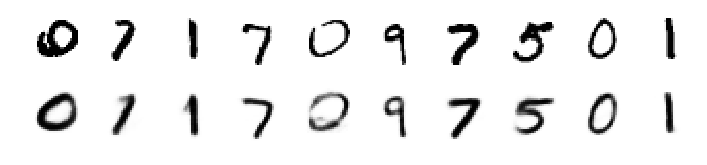

In [65]:
from keras.models import load_model

n_digits = 10
n_codings = 20 #from the encoder number

#model_file = 'models/auto/mnist/k_auto_var2-model'
#model = load_model(model_file + '.h5')

images_in, _ = random_batch(X_test, y_test, batch_size=n_digits)
images_out = model.predict(images_in)

fig = plt.figure(figsize=(12, 2.5))
for digit_index in range(n_digits):
    plt.subplot(2, n_digits, digit_index + 1)
    plot_image(images_in[digit_index].reshape(28,28))
    
    plt.subplot(2, n_digits, n_digits + digit_index + 1)
    plot_image(images_out[digit_index].reshape(28,28))
plt.show()

### Encoding Distributions

In [66]:
from keras.models import load_model

#encoder_file = 'models/auto/mnist/k_auto_var2-enc'
#encoder = load_model(encoder_file + '.h5')
#encoder.compile(loss='binary_crossentropy', optimizer="adam")

# encoder_output contains 3 variables: [ codings, param_0, param_1 ]
encoder_output = encoder.predict(X_test, verbose=True)
print(encoder_output[0].shape)

10000/10000 [==============================] - 1s 59us/step
(10000, 24)


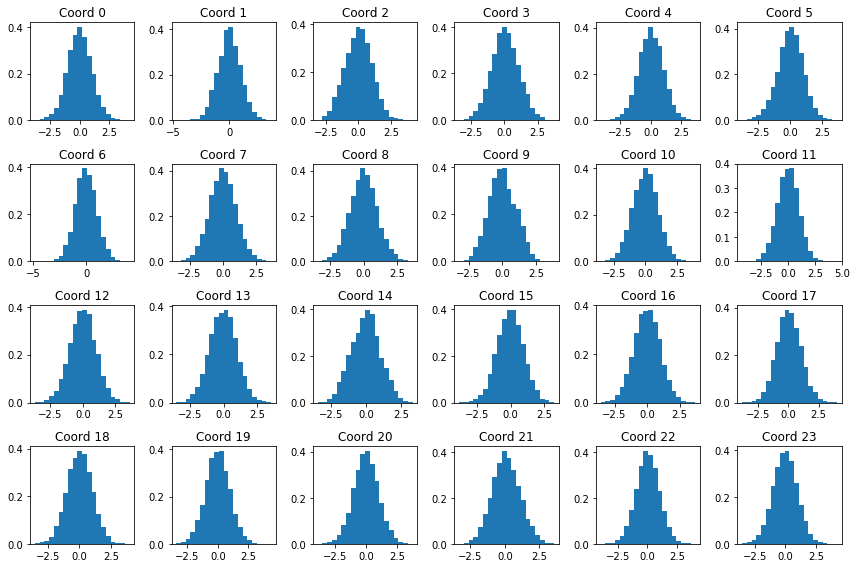

In [67]:
X_encoded = encoder_output[0]
showAll = True

coord_indeces = np.array([
    [ 0, 1, 2, 3, 4],
    [ 5, 6, 7, 8, 9]
])

if showAll:
    n_cols = 6
    n_rows = X_encoded.shape[1] // n_cols
else:
    n_cols = coord_indeces.shape[1]
    n_rows = coord_indeces.shape[0]

plt.figure(figsize=(12, int(12.0/n_cols * n_rows)))
for row in range(n_rows):
    for col in range(n_cols):
        i = row * n_cols + col
        plt.subplot(n_rows, n_cols, i + 1)
        if showAll:
            plt.title("Coord " + str(i))
            plt.hist(X_encoded[:, i], bins=20, density=True)
        else:
            plt.title("Coord " + str(coord_indeces[row, col]))
            plt.hist(X_encoded[:, coord_indeces[row, col]], bins=20, density=True)
plt.tight_layout()
plt.show()

### Generative

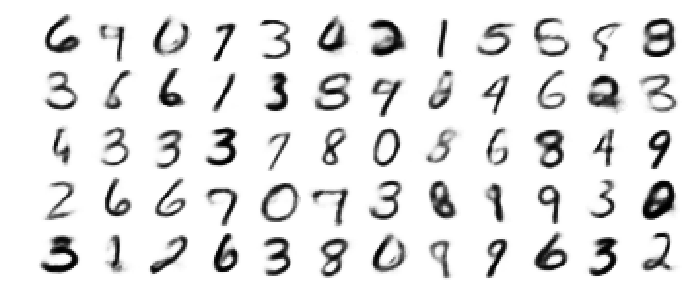

In [68]:
from keras.models import load_model

rows = 5
cols = 12
n_digits = rows * cols

#decoder_file = 'models/auto/mnist/k_auto_var2-dec'
#decoder = load_model(decoder_file + '.h5')
#decoder.compile(loss='binary_crossentropy', optimizer="adam")
n_codings = decoder.layers[0].input_shape[1]

#codings_in = noise = np.random.uniform(-2, 2, n_digits * n_codings).reshape((n_digits, n_codings))
codings_in = noise = np.random.normal(0, 1.0, n_digits * n_codings).reshape((n_digits, n_codings))
images_out = decoder.predict(codings_in)

image = combine_images(images_out, rows, cols)

fig = plt.figure(figsize=(cols, rows))
plt.imshow(image, cmap="Greys", interpolation='nearest')
plt.axis("off")
plt.show()

## Interpolating digits

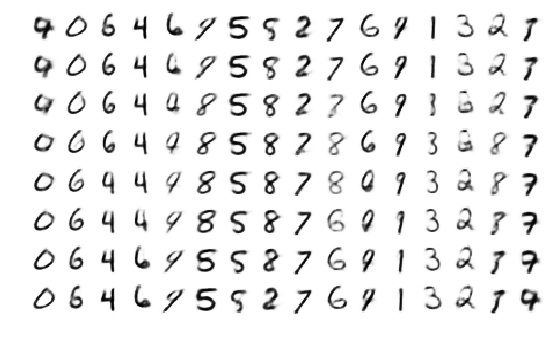

In [69]:
from keras.models import load_model

n_digits = 16
n_iterations = 7

#decoder_file = 'models/auto/mnist/k_auto_var2-dec'
#decoder = load_model(decoder_file + '.h5')
#decoder.compile(loss='binary_crossentropy', optimizer="adam")
n_codings = decoder.layers[0].input_shape[1]

#codings_in = noise = np.random.uniform(-2, 2, n_digits * n_codings).reshape((n_digits, n_codings))
codings_in = noise = np.random.normal(0, 1.0, n_digits * n_codings).reshape((n_digits, n_codings))
codings_target = target_codings = np.roll(codings_in, -1, axis=0)
difference = codings_target - codings_in

images = []

for iteration in range(n_iterations + 1):
    codings_interpolate = codings_in + difference * iteration / n_iterations
    images_out = decoder.predict(codings_interpolate)
    image = combine_images(images_out, rows=1, cols=n_digits)
    images.append(image)


fig = plt.figure(figsize=(0.8*n_digits, 0.8*n_iterations))
for i in range(n_iterations + 1):
    plt.subplot(n_iterations+1, 1, i+1)
    plt.imshow(images[i], cmap="Greys", interpolation='nearest')
    plt.axis("off")

plt.show()

In [70]:
start_fresh = True
next_pid = 1

n_epochs = 10
batch_size = 100
n_batches = X_train.shape[0] // batch_size

see_changes = True #use the same noise for output images, to track changes4
show_zero = False


if see_changes:
    if start_fresh:
        #enc_const = np.random.normal(-1, 1, batch_size * n_codings).reshape((batch_size, n_codings))
        enc_const = np.random.uniform(-1, 1, batch_size * n_codings).reshape((batch_size, n_codings))
    else:
        try:
            enc_const
        except NameError:
            #enc_const = np.random.normal(0, 1, batch_size * n_codings).reshape((batch_size, n_codings))
            enc_const = np.random.uniform(-1, 1, batch_size * n_codings).reshape((batch_size, n_codings))

if start_fresh:
    pic_epoch_id = 0
else:
    pic_epoch_id = next_pid #continue from this epoch - must be set by hand
    encoder.load_weights(encoder_file + '.' + str(next_pid - 1))
    decoder.load_weights(decoder_file + '.' + str(next_pid - 1))

epoch = pic_epoch_id
max_epoch = n_epochs + pic_epoch_id
noise_zero = np.zeros((1, n_codings))

print("Training for", n_epochs, "epochs with", n_batches, "batches of size", batch_size, end="")

while epoch < max_epoch:
    losses = []
    for iteration in range(n_batches):
        random_indeces = np.random.randint(0, X_train.shape[0], batch_size)
        X_batch = X_train[random_indeces]
        
        loss = model.train_on_batch(X_batch, X_batch)
        losses.append(loss)
        
        print("\rEpoch {:3}: {:3}% | loss: {:3.4f}".format(
                epoch, 100 * iteration // n_batches, loss), end="")
        sys.stdout.flush()
        
        if show_zero:
            image0 = combine_images(generator.predict(noise_zero), 1, 1) * 255
            Image.fromarray(image0.astype(np.uint8)).save(
                    save_path0 + str(epoch) + "_" + str(iteration) + ".png")
        
        if iteration % (n_batches // 1) == 0:
            if see_changes:
                fake_images = generator.predict(noise_const, verbose=0)
            image = combine_images(fake_images)
            image = image * 255
            Image.fromarray(image.astype(np.uint8)).save(
                save_path + str(epoch) + ".png")
        
        if iteration % (n_batches // 1) == 0:
            generator.save_weights(gen_file + "." + str(epoch), True)
            generator.save_weights(gen_file, True)
            discriminator.save_weights(disc_file + "." + str(epoch), True)
            discriminator.save_weights(disc_file, True)
    
    print()
    epoch += 1
    pic_epoch_id = epoch

print("Training finished.")

Training for 10 epochs with 600 batches of size 100

ValueError: ('Error when checking model target: expected no data, but got:', array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       ...,


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]]], dtype=float32))